[I 2025-06-22 19:04:44,380] A new study created in memory with name: no-name-261ab830-8d31-45fc-bd68-9ab54de1c367


Usando dispositivo: cuda
Forma inicial del dataset: (3680, 20)
Columnas: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

Número de barrios únicos: 10
Número de estratos únicos: 3

Forma datos entrenamiento: (3150, 30)
Forma datos validación: (530, 30)
Rango de años en entrenamiento: 2015 - 2020
Rango de años en validación: 2021 - 2021

Forma X_train: (3098, 52, 29)
Forma y_train: (3098,)
Forma X_val: (478, 52, 29)
Forma y_val: (478,)
Número de características: 29

Iniciando optimización de hiperparámetros con Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-22 19:04:55,968] Trial 0 finished with value: 0.0023041982203722 and parameters: {'n_units': 96, 'learning_rate': 0.0036884177739498064, 'dropout_rate': 0.4869028537738429, 'n_layers': 2, 'batch_size': 32}. Best is trial 0 with value: 0.0023041982203722.
[I 2025-06-22 19:05:10,861] Trial 1 finished with value: 0.0024568610824644566 and parameters: {'n_units': 160, 'learning_rate': 0.0005932789979323596, 'dropout_rate': 0.37207464861701023, 'n_layers': 1, 'batch_size': 32}. Best is trial 0 with value: 0.0023041982203722.
[I 2025-06-22 19:05:27,202] Trial 2 finished with value: 0.0024551101960241795 and parameters: {'n_units': 192, 'learning_rate': 0.0011753135306519344, 'dropout_rate': 0.24728694389380892, 'n_layers': 1, 'batch_size': 32}. Best is trial 0 with value: 0.0023041982203722.
[I 2025-06-22 19:05:30,018] Trial 3 finished with value: 0.0023695973213762045 and parameters: {'n_units': 96, 'learning_rate': 0.0012371390359859427, 'dropout_rate': 0.2997259976111917, 'n_la

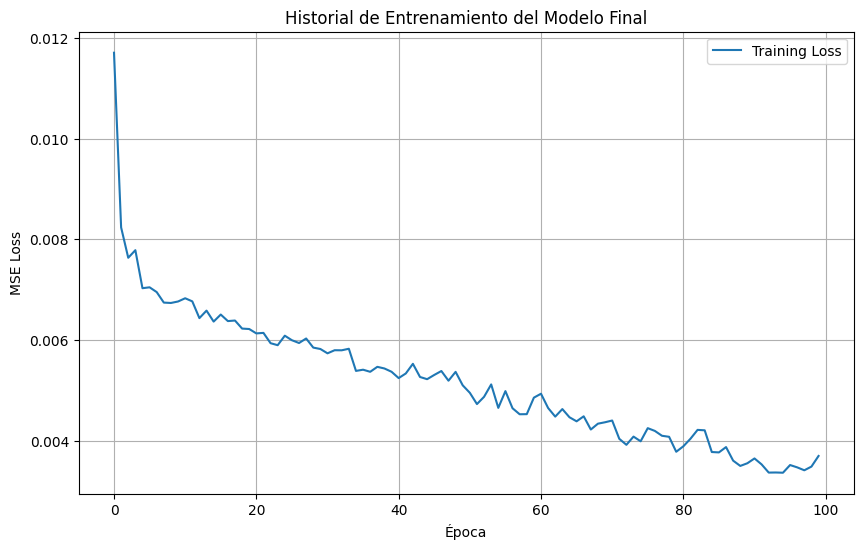


Número de barrios a pronosticar: 10

Generando pronósticos para barrio 0...

Generando pronósticos para barrio 1...

Generando pronósticos para barrio 2...

Generando pronósticos para barrio 3...

Generando pronósticos para barrio 4...

Generando pronósticos para barrio 5...

Generando pronósticos para barrio 6...

Generando pronósticos para barrio 7...

Generando pronósticos para barrio 8...

Generando pronósticos para barrio 9...

Forma del archivo de submission: (520, 2)
Primeras filas:
          id    dengue
0  0_2022_01  3.338366
1  0_2022_02  3.885648
2  0_2022_03  4.317502
3  0_2022_04  4.522111
4  0_2022_05  6.196944
5  0_2022_06  8.244981
6  0_2022_07  8.320756
7  0_2022_08  8.326799
8  0_2022_09  8.164601
9  0_2022_10  8.031448

Últimas filas:
            id     dengue
510  9_2022_43   9.750361
511  9_2022_44   9.878816
512  9_2022_45   9.975528
513  9_2022_46  10.036136
514  9_2022_47  10.077988
515  9_2022_48  10.107142
516  9_2022_49  10.136689
517  9_2022_50  10.199942
5


¡Proceso completado exitosamente!


In [1]:
# Modelo LSTM Multivariado para Pronóstico de Dengue por Barrio

# 1. Carga y Configuración

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import optuna
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Semilla para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

# Carga de datos
df = pd.read_parquet('../../Datos/df_train.parquet')
print(f"Forma inicial del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

# 2. Análisis Exploratorio y Preprocesamiento

# Crear fecha real usando semanas ISO
def create_date_from_year_week(year, week):
    """Crea una fecha a partir del año y número de semana ISO"""
    # Primer día del año
    jan1 = datetime(year, 1, 1)
    # Encontrar el primer lunes del año
    days_to_monday = (7 - jan1.weekday()) % 7
    first_monday = jan1 + timedelta(days=days_to_monday)
    # Calcular la fecha de la semana
    target_date = first_monday + timedelta(weeks=week-1)
    return target_date

# Aplicar la función para crear las fechas
df['fecha'] = df.apply(lambda row: create_date_from_year_week(row['anio'], row['semana']), axis=1)
df = df.set_index('fecha')
df = df.sort_index()

# Verificar la distribución de barrios
print(f"\nNúmero de barrios únicos: {df['id_bar'].nunique()}")
print(f"Número de estratos únicos: {df['ESTRATO'].nunique()}")

# Identificar columnas numéricas (excluyendo las que vamos a codificar)
categorical_cols = ['id_bar', 'ESTRATO']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['anio', 'semana', 'dengue']]
target_col = 'dengue'

# One-Hot Encoding para variables categóricas
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)

# Separar características de la variable objetivo
feature_cols = [col for col in df_encoded.columns if col not in ['anio', 'semana', target_col]]
X = df_encoded[feature_cols].values
y = df_encoded[target_col].values.reshape(-1, 1)

# Escalado de datos
# Escalar características
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar variable objetivo
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Crear DataFrame escalado para facilitar la división temporal
df_scaled = pd.DataFrame(
    np.hstack([X_scaled, y_scaled]),
    columns=feature_cols + [target_col],
    index=df_encoded.index
)
df_scaled['anio'] = df_encoded['anio']

# División de datos
train_data = df_scaled[df_scaled['anio'] < 2021]
val_data = df_scaled[df_scaled['anio'] >= 2021]

print(f"\nForma datos entrenamiento: {train_data.shape}")
print(f"Forma datos validación: {val_data.shape}")
print(f"Rango de años en entrenamiento: {train_data['anio'].min()} - {train_data['anio'].max()}")
print(f"Rango de años en validación: {val_data['anio'].min()} - {val_data['anio'].max()}")

# 3. Creación de Secuencias

def create_sequences(data, sequence_length=52):
    """
    Crea secuencias para el modelo LSTM.
    
    Args:
        data: DataFrame con los datos escalados
        sequence_length: Longitud de la secuencia de entrada (52 semanas = 1 año)
    
    Returns:
        X: Secuencias de entrada
        y: Valores objetivo
    """
    # Excluir la columna 'anio' para las secuencias
    data_for_sequences = data.drop('anio', axis=1)
    
    X, y = [], []
    
    for i in range(len(data_for_sequences) - sequence_length):
        # Secuencia de entrada: todas las características
        X.append(data_for_sequences.iloc[i:i+sequence_length].values)
        # Valor objetivo: solo la columna 'dengue' del siguiente paso temporal
        y.append(data_for_sequences.iloc[i+sequence_length][target_col])
    
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento y validación
sequence_length = 52
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)

print(f"\nForma X_train: {X_train.shape}")
print(f"Forma y_train: {y_train.shape}")
print(f"Forma X_val: {X_val.shape}")
print(f"Forma y_val: {y_val.shape}")

# Número de características
n_features = X_train.shape[2]
print(f"Número de características: {n_features}")

# 4. Optimización de Hiperparámetros con Optuna

# Definir el modelo LSTM en PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Inicializar hidden state y cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decodificar la salida del último paso temporal
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

def objective(trial):
    """Función objetivo para Optuna"""
    
    # Hiperparámetros a optimizar
    n_units = trial.suggest_int('n_units', 32, 256, step=32)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Crear modelo
    model = LSTMModel(n_features, n_units, n_layers, dropout_rate).to(device)
    
    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Convertir datos a tensores
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Crear DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Entrenar modelo
    n_epochs = 50
    model.train()
    
    for epoch in range(n_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluar en validación
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred.squeeze(), y_val_tensor)
    
    return val_loss.item()

# Ejecutar optimización con Optuna
print("\nIniciando optimización de hiperparámetros con Optuna...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nMejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor MSE en validación: {study.best_value:.6f}")

# 5. Entrenamiento del Modelo Final

# Extraer mejores hiperparámetros
best_params = study.best_params

# Combinar datos de entrenamiento y validación para el entrenamiento final
all_data = pd.concat([train_data, val_data])
X_all, y_all = create_sequences(all_data, sequence_length)

print(f"\nForma datos combinados X_all: {X_all.shape}")
print(f"Forma datos combinados y_all: {y_all.shape}")

# Crear modelo final con mejores hiperparámetros
final_model = LSTMModel(
    n_features, 
    best_params['n_units'], 
    best_params['n_layers'], 
    best_params['dropout_rate']
).to(device)

# Configurar entrenamiento
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

# Convertir a tensores
X_all_tensor = torch.FloatTensor(X_all).to(device)
y_all_tensor = torch.FloatTensor(y_all).to(device)

# Crear DataLoader
all_dataset = TensorDataset(X_all_tensor, y_all_tensor)
all_loader = DataLoader(all_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Entrenar modelo final
n_epochs_final = 100
train_losses = []

print("\nEntrenando modelo final...")
final_model.train()

for epoch in range(n_epochs_final):
    epoch_loss = 0
    n_batches = 0
    
    for batch_X, batch_y in all_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{n_epochs_final}], Loss: {avg_loss:.6f}")

# Gráfica del historial de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Historial de Entrenamiento del Modelo Final')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# 6. Generación de Pronósticos para 2022

# Obtener los datos originales para preparar las predicciones
df_original = pd.read_parquet('../../Datos/df_train.parquet')
df_original['fecha'] = df_original.apply(
    lambda row: create_date_from_year_week(row['anio'], row['semana']), axis=1
)
df_original = df_original.set_index('fecha').sort_index()

# Identificar todos los barrios únicos
unique_bars = sorted(df_original['id_bar'].unique())
print(f"\nNúmero de barrios a pronosticar: {len(unique_bars)}")

# Preparar DataFrame para almacenar pronósticos
predictions_2022 = []

# Para cada barrio
for id_bar in unique_bars:
    print(f"\nGenerando pronósticos para barrio {id_bar}...")
    
    # Filtrar datos del barrio específico
    bar_data = df_original[df_original['id_bar'] == id_bar].copy()
    
    # Aplicar el mismo preprocesamiento
    bar_encoded = pd.get_dummies(bar_data, columns=categorical_cols, prefix=categorical_cols)
    
    # Asegurar que tengamos todas las columnas necesarias
    for col in feature_cols:
        if col not in bar_encoded.columns:
            bar_encoded[col] = 0
    
    bar_encoded = bar_encoded[feature_cols + [target_col]]
    
    # Escalar datos
    X_bar = scaler_X.transform(bar_encoded[feature_cols].values)
    y_bar = scaler_y.transform(bar_encoded[target_col].values.reshape(-1, 1))
    
    # Crear DataFrame escalado
    bar_scaled = pd.DataFrame(
        np.hstack([X_bar, y_bar]),
        columns=feature_cols + [target_col],
        index=bar_encoded.index
    )
    
    # Tomar las últimas 52 semanas como secuencia inicial
    last_sequence = bar_scaled.iloc[-sequence_length:].values
    current_sequence = last_sequence.copy()
    
    # Generar pronósticos para las 52 semanas de 2022
    final_model.eval()
    
    for week in range(1, 53):
        # Convertir secuencia a tensor
        seq_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
        
        # Hacer predicción
        with torch.no_grad():
            pred_scaled = final_model(seq_tensor).cpu().numpy()[0, 0]
        
        # Des-escalar predicción
        pred_original = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
        
        # Asegurar que la predicción no sea negativa
        pred_original = max(0, pred_original)
        
        # Almacenar predicción
        predictions_2022.append({
            'id': f"{id_bar}_2022_{week:02d}",
            'dengue': pred_original
        })
        
        # Preparar siguiente entrada
        # Crear vector de características para el nuevo punto temporal
        new_features = current_sequence[-1, :-1].copy()  # Copiar últimas características (sin dengue)
        new_point = np.append(new_features, pred_scaled)
        
        # Actualizar secuencia: eliminar el más antiguo y añadir el nuevo
        current_sequence = np.vstack([current_sequence[1:], new_point])

# 7. Creación del Archivo de Submission

# Crear DataFrame con predicciones
df_submission = pd.DataFrame(predictions_2022)

# Verificar formato
print(f"\nForma del archivo de submission: {df_submission.shape}")
print(f"Primeras filas:")
print(df_submission.head(10))
print(f"\nÚltimas filas:")
print(df_submission.tail(10))

# Verificar estadísticas de las predicciones
print(f"\nEstadísticas de las predicciones:")
print(df_submission['dengue'].describe())

# Guardar archivo
df_submission.to_csv('pronosticos_dengue_2022.csv', index=False)
print(f"\nArchivo 'pronosticos_dengue_2022.csv' guardado exitosamente!")

# Visualización de algunas predicciones
fig = go.Figure()

# Mostrar predicciones para los primeros 5 barrios
sample_bars = unique_bars[:5]
for id_bar in sample_bars:
    bar_preds = df_submission[df_submission['id'].str.startswith(f"{id_bar}_")]
    weeks = [int(x.split('_')[-1]) for x in bar_preds['id']]
    
    fig.add_trace(go.Scatter(
        x=weeks,
        y=bar_preds['dengue'],
        mode='lines+markers',
        name=f'Barrio {id_bar}'
    ))

fig.update_layout(
    title='Pronósticos de Dengue 2022 - Muestra de 5 Barrios',
    xaxis_title='Semana del Año',
    yaxis_title='Casos de Dengue Pronosticados',
    hovermode='x unified'
)

fig.show()

print("\n¡Proceso completado exitosamente!")